# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

# 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
from  matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, precision_score
from sklearn.utils import shuffle
from sklearn.metrics import  roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import random
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import r2_score 
from scipy import stats as st

In [2]:
g_d_0 = pd.read_csv('/datasets/geo_data_0.csv')
g_d_1 = pd.read_csv('/datasets/geo_data_1.csv')
g_d_2 = pd.read_csv('/datasets/geo_data_2.csv')

Изучим данные по первому региону

In [3]:
g_d_0.head(3), g_d_0.shape  

(      id        f0        f1        f2     product
 0  txEyH  0.705745 -0.497823  1.221170  105.280062
 1  2acmU  1.334711 -0.340164  4.365080   73.037750
 2  409Wp  1.022732  0.151990  1.419926   85.265647,
 (100000, 5))

In [4]:
g_d_0['id'].unique().shape 

(99990,)

В данным есть дубликаты ( индексы скважин повторяются). Есть лишний столбец с индексами. Удалим дубли, а затем лишний столбец. 

In [5]:
g_d_0.drop_duplicates(subset=['id'], inplace = True)
g_d_0.drop(['id'], axis = 1 , inplace = True)

In [6]:
g_d_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99990 entries, 0 to 99999
Data columns (total 4 columns):
f0         99990 non-null float64
f1         99990 non-null float64
f2         99990 non-null float64
product    99990 non-null float64
dtypes: float64(4)
memory usage: 3.8 MB


Построим графики распределения величин датасета

Text(0.5, 1.0, 'product')

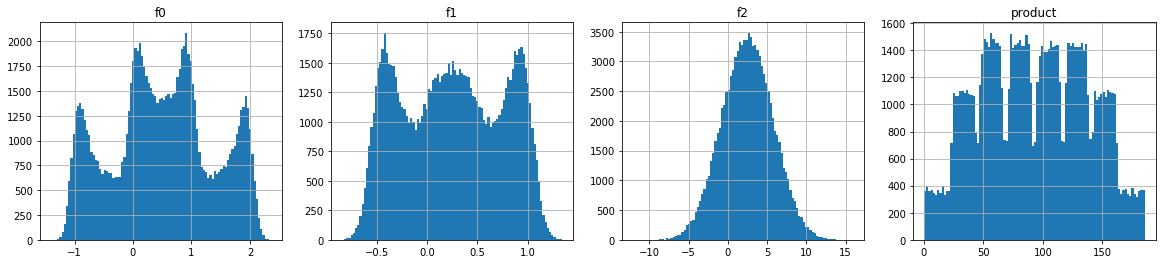

In [7]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4));
g_d_0['f0'].hist(ax=axes[0], bins = 100)
axes[0].set_title('f0')
g_d_0['f1'].hist(ax=axes[1], bins = 100)
axes[1].set_title('f1')
g_d_0['f2'].hist(ax=axes[2], bins = 100)
axes[2].set_title('f2')
g_d_0['product'].hist(ax=axes[3], bins = 100)
axes[3].set_title('product')

Построим матрицу корреляции. 

In [8]:
print(g_d_0.corr())

               f0        f1        f2   product
f0       1.000000 -0.440717 -0.003211  0.143504
f1      -0.440717  1.000000  0.001764 -0.192351
f2      -0.003211  0.001764  1.000000  0.483631
product  0.143504 -0.192351  0.483631  1.000000


По графикам не видно взаимосвязи с целевым признаком. Наибольшую корреляцию c целевым признаком  имеет признак f2, но и он не отражает характерные пики на целевом признаке. Скорее всего модель будет давать серьезную ошибку в предсказаниях.  

То же самое проделаем с датасетом по второму региону.

In [9]:
g_d_1.head(3), g_d_1.shape 

(      id         f0        f1        f2     product
 0  kBEdx -15.001348 -8.276000 -0.005876    3.179103
 1  62mP7  14.272088 -3.475083  0.999183   26.953261
 2  vyE1P   6.263187 -5.948386  5.001160  134.766305,
 (100000, 5))

In [10]:
g_d_1['id'].unique().shape

(99996,)

Удалим дубли, а затем лишний столбец.

In [11]:
g_d_1.drop_duplicates(subset=['id'], inplace = True)
g_d_1.drop(['id'], axis = 1 , inplace = True)

In [12]:
g_d_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 4 columns):
f0         99996 non-null float64
f1         99996 non-null float64
f2         99996 non-null float64
product    99996 non-null float64
dtypes: float64(4)
memory usage: 3.8 MB


Построим графики распределения величин датасета и корреляционную матрицу

Text(0.5, 1.0, 'product')

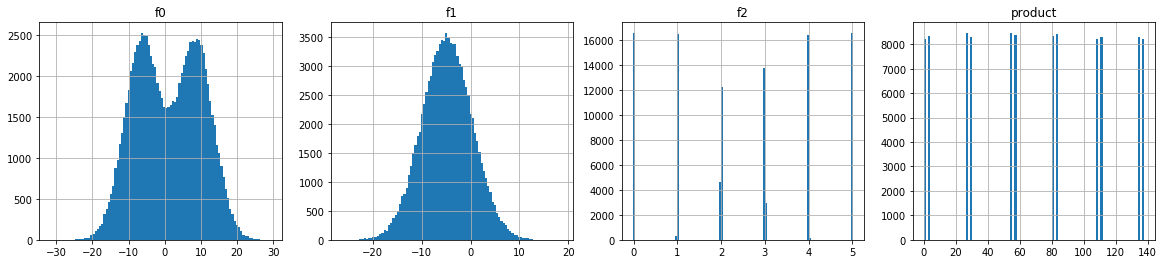

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4));
g_d_1['f0'].hist(ax=axes[0], bins = 100)
axes[0].set_title('f0')
g_d_1['f1'].hist(ax=axes[1], bins = 100)
axes[1].set_title('f1')
g_d_1['f2'].hist(ax=axes[2], bins = 100)
axes[2].set_title('f2')
g_d_1['product'].hist(ax=axes[3], bins = 100)
axes[3].set_title('product')

In [14]:
print(g_d_1.corr())

               f0        f1        f2   product
f0       1.000000  0.182279 -0.001810 -0.030523
f1       0.182279  1.000000 -0.002594 -0.010154
f2      -0.001810 -0.002594  1.000000  0.999397
product -0.030523 -0.010154  0.999397  1.000000


В данном датасете имеется очевидная  зависимость целевого признака от f2. Остальные признаки не коррелируют с ним. 

То же самое проделаем с датасетом по третьему региону.

In [15]:
g_d_2.head(3) 

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910


In [16]:
g_d_2['id'].unique().shape

(99996,)

In [17]:
g_d_2.drop_duplicates(subset=['id'], inplace = True)
g_d_2.drop(['id'], axis = 1 , inplace = True)

In [18]:
g_d_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99996 entries, 0 to 99999
Data columns (total 4 columns):
f0         99996 non-null float64
f1         99996 non-null float64
f2         99996 non-null float64
product    99996 non-null float64
dtypes: float64(4)
memory usage: 3.8 MB


Text(0.5, 1.0, 'product')

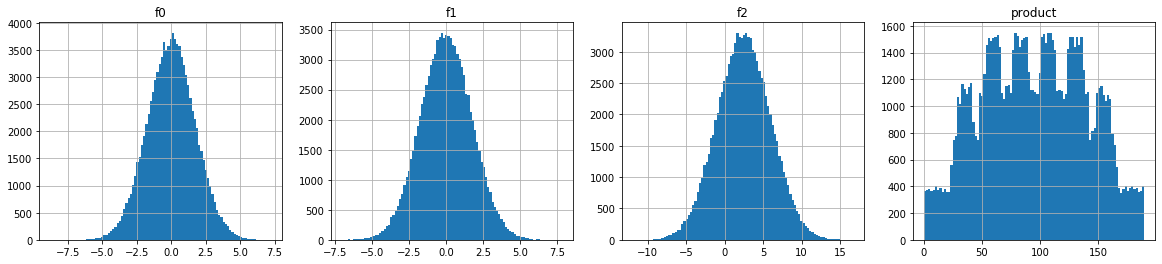

In [19]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4));
g_d_2['f0'].hist(ax=axes[0], bins = 100)
axes[0].set_title('f0')
g_d_2['f1'].hist(ax=axes[1], bins = 100)
axes[1].set_title('f1')
g_d_2['f2'].hist(ax=axes[2], bins = 100)
axes[2].set_title('f2')
g_d_2['product'].hist(ax=axes[3], bins = 100)
axes[3].set_title('product')

In [20]:
print(g_d_2.corr())

               f0        f1        f2   product
f0       1.000000  0.000506 -0.000452 -0.001978
f1       0.000506  1.000000  0.000753 -0.001055
f2      -0.000452  0.000753  1.000000  0.445867
product -0.001978 -0.001055  0.445867  1.000000


Ситуация схожа с первым регионом. С целевым признаком коррелирует f2. 

Разобьем датасет первого региона на тестовую и валидационную выборку.

In [21]:
features_0 = g_d_0.drop(["product"], axis=1)
target_0 = g_d_0["product"]
features_0_train, features_0_valid,target_0_train, target_0_valid  = train_test_split(features_0 ,target_0,
                                                                                      test_size=0.25, random_state=12345)

In [22]:
features_0_train.shape, features_0_valid.shape

((74992, 3), (24998, 3))

Разобьем датасет второго региона на тестовую и валидационную выборку

In [23]:
features_1 = g_d_1.drop(["product"], axis=1)
target_1 = g_d_1["product"]
features_1_train, features_1_valid,target_1_train, target_1_valid  = train_test_split(features_1 ,target_1,
                                                                                      test_size=0.25, random_state=12345)

In [24]:
features_1_train.shape, features_1_valid.shape

((74997, 3), (24999, 3))

Разобьем датасет третьего региона на тестовую и валидационную выборку

In [25]:
features_2 = g_d_2.drop(["product"], axis=1)
target_2 = g_d_2["product"]
features_2_train, features_2_valid,target_2_train, target_2_valid  = train_test_split(features_2 ,target_2,
                                                                                      test_size=0.25, random_state=12345)

In [26]:
features_2_train.shape, features_2_valid.shape

((74997, 3), (24999, 3))

# 2. Обучение и проверка модели

Обучим модель на первом регионе

In [27]:
logres_0 =  LinearRegression()
logres_0.fit(features_0_train, target_0_train)
predicted_valid_0 = logres_0.predict(features_0_valid)
mse = mean_squared_error(target_0_valid, predicted_valid_0)
print('Средний запас предсказанного сырья',predicted_valid_0.mean())
print("RMSE =", mse ** 0.5)
print("R2 =", r2_score(target_0_valid,predicted_valid_0))

Средний запас предсказанного сырья 92.78915638280621
RMSE = 37.853527328872964
R2 = 0.2723923460817068


Средний запас высокий , но ошибка в предсказаниях более 40% от запаса. Качество модели позволяет получать предсказания
немногим точнее чем просто среднее.

In [28]:
logres_1 =  LinearRegression()
logres_1.fit(features_1_train, target_1_train)
predicted_valid_1 = logres_1.predict(features_1_valid )
mse = mean_squared_error(target_1_valid, predicted_valid_1)
print('Средний запас предсказанного сырья',predicted_valid_1.mean())
print("RMSE =", mse ** 0.5)
print("R2 =", r2_score(target_1_valid,predicted_valid_1))

Средний запас предсказанного сырья 69.17831957030431
RMSE = 0.892059264771702
R2 = 0.9996222988190184


Средний запас самый низкий  , но очень маленькая ошибка  1 %. Это значить если отобрать скважины с показателями указывающими на высокий запас. 
Мы почти не рискуем

In [29]:
logres_2 =  LinearRegression()
logres_2.fit(features_2_train, target_2_train)
predicted_valid_2 = logres_2.predict(features_2_valid )
mse = mean_squared_error(target_2_valid, predicted_valid_2)
print('Средний запас предсказанного сырья',predicted_valid_2.mean())
print("RMSE =", mse ** 0.5)
print("R2 =", r2_score(target_2_valid,predicted_valid_2))

Средний запас предсказанного сырья 94.86572480562035
RMSE = 40.07585073246016
R2 = 0.19556241810202346


Самый высокий средний запас, но точность и качество предсказания самые низкие. 

# 3. Подготовка к расчёту прибыли

Введем константы

In [30]:
budget = 10000000000 # бюджет
wells = 200 # количество скважин
bbl_price = 450 # цена барреля нефти

Посчитаем безубыточный уровень запаса скважины

In [31]:
profit = 0 #безубыточный уровень дохода
cost_price = budget/wells # затраты на одну скважину
mean_stock = (profit+cost_price)/bbl_price # средний сток в тысячах баррелей  
print(mean_stock/1000, 'тыс. баррелей' )

111.11111111111111 тыс. баррелей


Безубыточный уровень скважины составляет 111 тыс. барелей. Это выше чем средний запас в каждом регионе. 
Что бы получить прибыль нужно искать скважины с более высокими запасами. 

# 4. Расчёт прибыли и рисков

Напишем функцию для подсчета прибыли с 200 скважин

In [32]:
def revenue(target,predictions):
    predictions = predictions.sort_values(ascending=False)
    top_200 = target[predictions.index][:wells]
    product = top_200.sum()
    income = product * bbl_price*1000
    profit = income - budget
    return profit

Найдем регион с уровнем риска убытка менее 2,5 %
Для этого случайнм образом отберем 500 скважин и из них 200 c наилучшим предсказанием. Посчитаем прибыль. 

Для оценки рисков проделаем процедуру 1000 раз и посмотрим какой процент из 1000 выборок имеет убыток. 
Это и будет уровень риска. 

Первый регион. 

Уровень риска: 7%
Доверительный интервал: (392436312.2689625, 426419764.9739094)
Квантиль 2,5%: -131536028.70
Ожидаемая выручка: 409428038.62


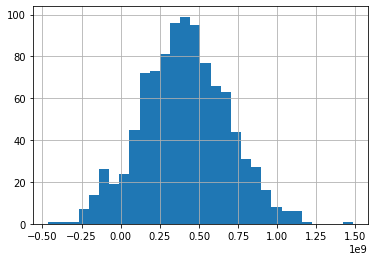

In [33]:
state = np.random.RandomState(seed = 12345)
values = []
target_0_valid.reset_index(drop = True, inplace = True)
for  i in range(1000):
    target_0_500 = target_0_valid.sample(n=500, replace = True, random_state = state)
    predictions = pd.Series(predicted_valid_0)[target_0_500.index]
    profit =  revenue(target_0_500,predictions)  
    values.append(revenue(target_0_500,predictions))
values = pd.Series(values) 
risk = (values<0).mean()
lower = values.quantile(0.025)
income_mean = values.mean()
confidence_interval = st.t.interval(0.95, len(values)-1, loc = values.mean(), scale = values.sem())
print('Уровень риска: {:.0%}'.format(risk))
print('Доверительный интервал:',confidence_interval)
print('Квантиль 2,5%: {:.2f}'.format(lower))
print('Ожидаемая выручка: {:.2f}'.format(income_mean))
values.hist(bins = 30)

Средняя выручка около 409 млн. Но нижний квантиль в отрицательной зоне. Это значить мы имеем риск влететь на убытки. 
Модель показывает риск в 7%. Уровень риска неприемлемый. 

Второй регион

Уровень риска: 1%
Доверительный интервал: (523348898.5869503, 550456276.3879564)
Квантиль 2,5%: 114527902.90
Ожидаемая выручка: 536902587.49


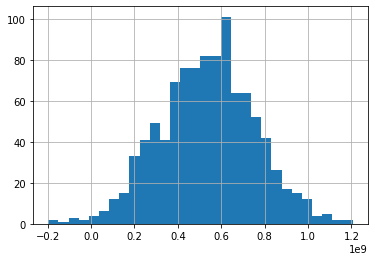

In [34]:
state = np.random.RandomState(seed = 12345)
values = []
target_1_valid.reset_index(drop = True, inplace = True)
for  i in range(1000):
    target_1_500 = target_1_valid.sample(n=500, replace = True, random_state = state)
    predictions = pd.Series(predicted_valid_1)[target_1_500.index]
    profit =  revenue(target_1_500,predictions)  
    values.append(revenue(target_1_500,predictions))
    if profit <0: risk += 1 
values = pd.Series(values) 
risk = (values<0).mean()
lower = values.quantile(0.025)
income_mean = values.mean()
confidence_interval = st.t.interval(0.95, len(values)-1, loc = values.mean(), scale = values.sem())
print('Уровень риска: {:.0%}'.format(risk))
print('Доверительный интервал:',confidence_interval)
print('Квантиль 2,5%: {:.2f}'.format(lower))
print('Ожидаемая выручка: {:.2f}'.format(income_mean))
values.hist(bins = 30)

Средняя выручка около 536 млн. Нижний квантиль в положителной зоне. 
Уровень риска 1% ,что приемлемо по условию задачи.

Третий регион

Уровень риска: 10%
Доверительный интервал: (336935105.9082979, 370645619.553586)
Квантиль 2,5%: -159194031.19
Ожидаемая выручка: 353790362.73


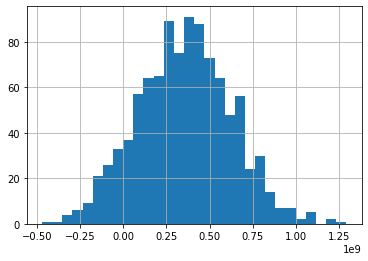

In [35]:
state = np.random.RandomState(seed = 12345)
values = []
target_2_valid.reset_index(drop = True, inplace = True)
for  i in range(1000):
    target_2_500 = target_2_valid.sample(n=500, replace = True, random_state = state)
    predictions = pd.Series(predicted_valid_2)[target_2_500.index]
    profit =  revenue(target_2_500,predictions)  
    values.append(revenue(target_2_500,predictions))
values = pd.Series(values) 
risk = (values<0).mean()
lower = values.quantile(0.025)
income_mean = values.mean()
confidence_interval = st.t.interval(0.95, len(values)-1, loc = values.mean(), scale = values.sem())
print('Уровень риска: {:.0%}'.format(risk))
print('Доверительный интервал:',confidence_interval)
print('Квантиль 2,5%: {:.2f}'.format(lower))
print('Ожидаемая выручка: {:.2f}'.format(income_mean))
values.hist(bins = 30)

Средняя выручка около 352 млн. Нижний квантиль в отрицательной зоне. Уровень риска 10% ,что не приемлемо по условию задачи.

Вывод:

Выбираем второй регион. Не смотря на самый низкий показатель запасов, мы имеем самую высокую прибыль, это связано с тем что гораздо точнее выбираем необходимые скважины. Если получится в первом и третьем регионе увеличить точность предсказания , то безусловно они бы принесли большую прибыль. 